In [9]:
import psycopg2
import os
from environs import Env
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import LocalOutlierFactor
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline

DATA_CSV = 'data.csv'
MODEL_FILE = 'autoencoder.keras'
EMBEDDINGS_FILE = 'embeddings.npy'
COMBINED_FEATURES_FILE = 'combined_features.npy'
LATLONG_SCALED_FILE = 'latlong_scaled.npy'
CLUSTERS_FILE = 'clusters.npy'

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

env = Env()
env.read_env("credentials.env")

DB_HOST = env("DB_HOST")
DB_NAME = env("DB_NAME")
DB_USER = env("DB_USER")
DB_PASSWORD = env("DB_PASSWORD")
DB_PORT = env("DB_PORT")

conn = psycopg2.connect(
    host=DB_HOST,
    database=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    port=DB_PORT,
)
cur = conn.cursor()

In [3]:
features = ['packet_loss', 'mdev_ping_rtt (ms)', 'latitude', 'longitude']

if os.path.exists(DATA_CSV):
    
    print("Reading existing data from CSV...")

    df = pd.read_csv(DATA_CSV)

else:
    
    print("No data.csv found. Running query and creating CSV.")

    query = """
    ROLLBACK;
    SELECT w.label, w.packet_loss, w.ping, e.latitude, e.longtitude
    FROM public.wifistats AS w
    JOIN public.extra_info AS e ON w.label = e.label
    WHERE e.latitude IS NOT NULL
      AND e.longtitude IS NOT NULL;
    """
    
    cur.execute(query)
    data = cur.fetchall()
    df = pd.DataFrame(data, columns=['label', 'packet_loss', 'ping_str', 'latitude', 'longitude'])

    pattern = r"min/avg/max/mdev = [\d\.]+/[\d\.]+/[\d\.]+/([\d\.]+) ms"
    df['mdev_ping_rtt (ms)'] = df['ping_str'].str.extract(pattern).astype(float)
    df.drop('ping_str', axis = 1, inplace = True)

    df[features] = df[features].apply(pd.to_numeric, errors = 'coerce')
    df = df.dropna(subset = features)

    df.to_csv(DATA_CSV, index = False)

X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Reading existing data from CSV...


In [4]:
if os.path.exists(MODEL_FILE):

    print("Loading existing autoencoder model from file...")

    autoencoder = models.load_model(MODEL_FILE)

else:
    print("No autoencoder model found. Building and training a new model.")

    input_dim = X_scaled.shape[1]
    encoding_dim = 2

    input_layer = layers.Input(shape = (input_dim,))
    encoded = layers.Dense(8, activation = 'relu')(input_layer)
    encoded = layers.Dense(encoding_dim, activation = 'relu')(encoded)

    decoded = layers.Dense(8, activation = 'relu')(encoded)
    decoded = layers.Dense(input_dim, activation = 'linear')(decoded)

    autoencoder = models.Model(inputs = input_layer, outputs = decoded)
    autoencoder.compile(optimizer = 'adam', loss = 'mse')

    autoencoder.fit(X_scaled, X_scaled, epochs = 10, batch_size = 256, shuffle = True, validation_split = 0.1)

    autoencoder.save(MODEL_FILE)

No autoencoder model found. Building and training a new model.


2024-12-14 01:00:42.443699: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10


2024-12-14 01:00:42.905362: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 59556320 exceeds 10% of free system memory.
2024-12-14 01:00:43.010043: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 59556320 exceeds 10% of free system memory.
2024-12-14 01:00:43.237286: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29778160 exceeds 10% of free system memory.
2024-12-14 01:00:43.240647: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29778160 exceeds 10% of free system memory.
2024-12-14 01:00:44.495195: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29778160 exceeds 10% of free system memory.


14541/14541 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - loss: 0.2170 - val_loss: 0.0343
Epoch 2/10
14541/14541 ━━━━━━━━━━━━━━━━━━━━ 14s 988us/step - loss: 0.0340 - val_loss: 0.0267
Epoch 3/10
14541/14541 ━━━━━━━━━━━━━━━━━━━━ 15s 991us/step - loss: 0.0289 - val_loss: 0.0291
Epoch 4/10
14541/14541 ━━━━━━━━━━━━━━━━━━━━ 14s 981us/step - loss: 0.0272 - val_loss: 0.0238
Epoch 5/10
14541/14541 ━━━━━━━━━━━━━━━━━━━━ 14s 979us/step - loss: 0.0265 - val_loss: 0.0234
Epoch 6/10
14541/14541 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.0262 - val_loss: 0.0206
Epoch 7/10
14541/14541 ━━━━━━━━━━━━━━━━━━━━ 14s 986us/step - loss: 0.0240 - val_loss: 0.0187
Epoch 8/10
14541/14541 ━━━━━━━━━━━━━━━━━━━━ 15s 1000us/step - loss: 0.0238 - val_loss: 0.0190
Epoch 9/10
14541/14541 ━━━━━━━━━━━━━━━━━━━━ 15s 996us/step - loss: 0.0237 - val_loss: 0.0181
Epoch 10/10
14541/14541 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.0236 - val_loss: 0.0183


In [5]:
if os.path.exists(EMBEDDINGS_FILE) and os.path.exists(COMBINED_FEATURES_FILE):
    print("Loading embeddings and combined_features from disk...")

    embeddings = np.load(EMBEDDINGS_FILE)
    combined_features = np.load(COMBINED_FEATURES_FILE)

else: 
    print("Computing embeddings and combined_features...")

    encoder = models.Model(inputs = autoencoder.input, outputs = autoencoder.layers[2].output)
    embeddings = encoder.predict(X_scaled)

    reconstructions = autoencoder.predict(X_scaled)
    reconstruction_error = np.mean((X_scaled - reconstructions)**2, axis = 1)

    combined_features = np.hstack([X_scaled, embeddings, reconstruction_error.reshape(-1, 1)])

    np.save(EMBEDDINGS_FILE, embeddings)
    np.save(COMBINED_FEATURES_FILE, combined_features) 

Computing embeddings and combined_features...
129246/129246 ━━━━━━━━━━━━━━━━━━━━ 68s 526us/step
129246/129246 ━━━━━━━━━━━━━━━━━━━━ 66s 514us/step


In [6]:
if os.path.exists(LATLONG_SCALED_FILE):

    print("Loading latlong_scaled from file...")
    latlong_scaled = np.load(LATLONG_SCALED_FILE)

else:

    print("latlong_scaled not found. Computing and saving it.")

    latlong = df[['latitude', 'longitude']].values 

    latlong_scaler = StandardScaler()
    latlong_scaled = latlong_scaler.fit_transform(latlong)

    np.save(LATLONG_SCALED_FILE, latlong_scaled)

if os.path.exists(CLUSTERS_FILE):

    print("Loading clusters from file...") 

    clusters = np.load(CLUSTERS_FILE) 
    df['cluster'] = clusters

else:
    print("No clusters found. Running and saving clusters.") 
    
    mbkmeans = MiniBatchKMeans(n_clusters = 20, batch_size = 1000, random_state = 69)
    clusters = mbkmeans.fit_predict(latlong_scaled)

    df['cluster'] = clusters
    np.save(CLUSTERS_FILE, clusters)

latlong_scaled not found. Computing and saving it.
No clusters found. Running and saving clusters.


In [7]:
df['anomaly'] = np.nan

unique_clusters = df['cluster'].unique()

for c in unique_clusters:

    cluster_mask = (df['cluster'] == c)
    combined_features_cluster = combined_features[cluster_mask]

    lof_cluster = LocalOutlierFactor(n_neighbors = 20, contamination = 'auto')
    cluster_labels = lof_cluster.fit_predict(combined_features_cluster)

    df.loc[cluster_mask, 'anomaly'] = cluster_labels

df['anomaly'] = df['anomaly'].astype(int)

In [8]:
anomalies = df[df['anomaly'] == -1]
print("Number of anomalies detected:", anomalies.shape[0])

high_packet_loss_threshold = anomalies['packet_loss'].quantile(0.95)
high_latency_variation_threshold = anomalies['mdev_ping_rtt (ms)'].quantile(0.95)

high_packet_loss_anomalies = anomalies[anomalies['packet_loss'] >= high_packet_loss_threshold]
high_latency_variation_anomalies = anomalies[anomalies['mdev_ping_rtt (ms)'] >= high_latency_variation_threshold]

anomaly_count_by_cluster = anomalies.groupby('cluster').size()
print("\nAnomaly count by cluster (physical region):")
print(anomaly_count_by_cluster)

Number of anomalies detected: 211385

Anomaly count by cluster (physical region):
cluster
0     13608
1      7243
2     13782
3     16344
4      8425
5      5293
6      4259
7     10661
8      3127
9     10439
10    21681
11     4445
12    14126
13     5175
14    23587
15     9522
16     4174
17    11206
18     2987
19    21301
dtype: int64


Columns in anomalies data: Index(['label', 'packet_loss', 'latitude', 'longitude', 'mdev_ping_rtt (ms)',
       'cluster', 'anomaly'],
      dtype='object')


/tmp/ipykernel_2053/98723153.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['latitude'] = pd.to_numeric(anomalies['latitude'], errors='coerce')
/tmp/ipykernel_2053/98723153.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['longitude'] = pd.to_numeric(anomalies['longitude'], errors='coerce')


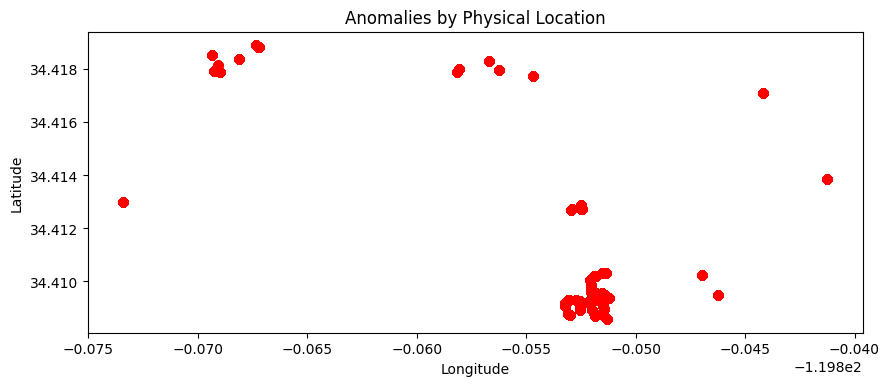

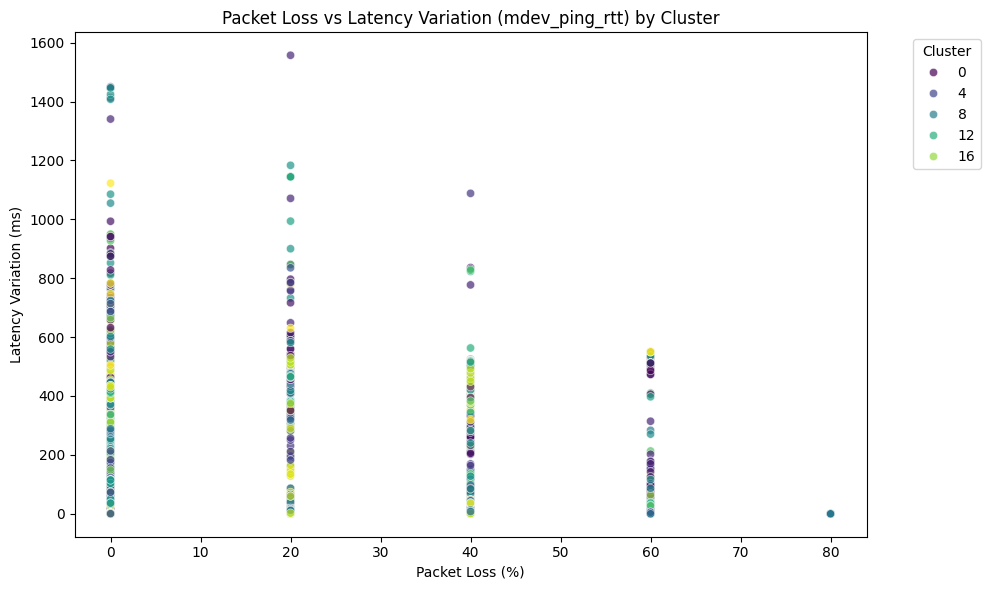

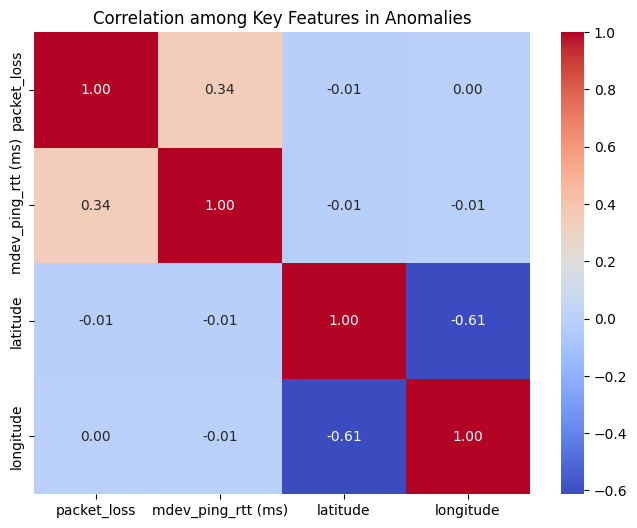

/tmp/ipykernel_2053/98723153.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='magma')


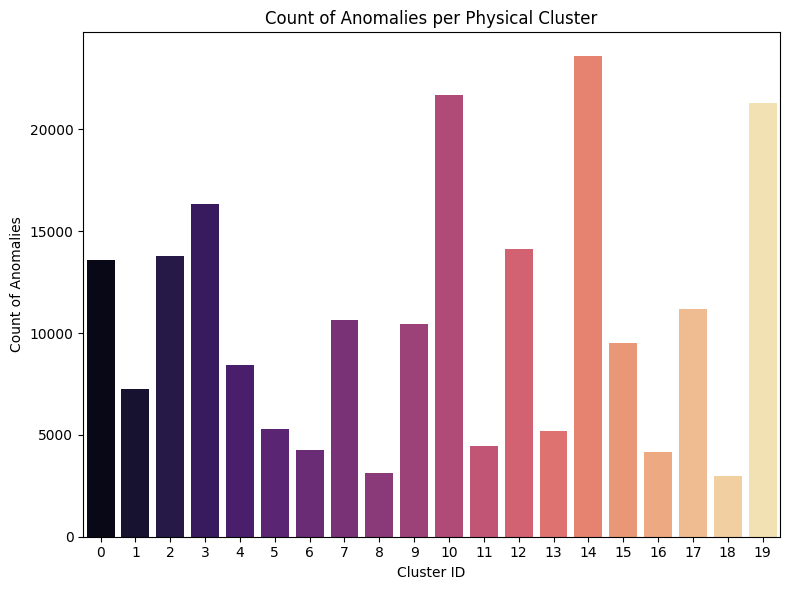

In [ ]:
anomalies['latitude'] = pd.to_numeric(anomalies['latitude'], errors = 'coerce')
anomalies['longitude'] = pd.to_numeric(anomalies['longitude'], errors = 'coerce')

anomalies = anomalies.dropna(subset = ['latitude', 'longitude'])

###########################
# Visualization 1: Geospatial Plot of Anomalies
###########################

gdf = gpd.GeoDataFrame(anomalies, geometry = [Point(xy) for xy in zip(anomalies['longitude'], anomalies['latitude'])], crs = "EPSG:4326")

fig, ax = plt.subplots(figsize = (10, 10))
gdf.plot(ax = ax, marker = 'o', c = 'red', alpha = 0.5)

ax.set_title("Anomalies by Physical Location")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.savefig('anomalies_geospatial.png', dpi = 300)
plt.show()
plt.close()

###########################
# Visualization 2: Scatter plot of Packet Loss vs. Latency Variation
###########################

plt.figure(figsize = (10, 6))
sns.scatterplot(data = anomalies, x = 'packet_loss', y = 'mdev_ping_rtt (ms)', hue = 'cluster', palette = 'viridis', alpha = 0.7)

plt.title('Packet Loss vs Latency Variation (mdev_ping_rtt) by Cluster')
plt.xlabel('Packet Loss (%)')
plt.ylabel('Latency Variation (ms)')

plt.legend(title = 'Cluster', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.tight_layout()

plt.savefig('anomalies_packetloss_latencyvariation.png', dpi = 300)
plt.show()
plt.close()

###########################
# Visualization 3: Correlation Heatmap of Key Features
###########################

corr = anomalies[features].corr()

plt.figure(figsize = (8, 6))
sns.heatmap(corr, annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title('Correlation among Key Features in Anomalies')
plt.savefig('anomalies_correlation.png', dpi = 300)
plt.show()
plt.close()

###########################
# Visualization 4: Distribution of Anomalies by Cluster
###########################

# Count how many anomalies per cluster
cluster_counts = anomalies['cluster'].value_counts()

plt.figure(figsize = (8,6))
sns.barplot(x = cluster_counts.index, y = cluster_counts.values, palette = 'magma')

plt.title('Count of Anomalies per Physical Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Count of Anomalies')

plt.tight_layout()
plt.savefig('anomalies_per_cluster.png', dpi = 300)
plt.show()
plt.close()

###########################
# Visualization 5: Interactive UCSB Map Plot
###########################

fig = px.scatter_mapbox(anomalies, lat = 'latitude', lon = 'longitude', hover_name = 'label', hover_data = {'packet_loss': True, 'mdev_ping_rtt (ms)': True, 'cluster': True}, color = 'packet_loss', size = 'mdev_ping_rtt (ms)', color_continuous_scale = 'Inferno', zoom = 12, height = 600)

fig.update_layout(mapbox_style = 'open-street-map', title = 'Interactive Map of Anomalous Devices (Size=Latency Variation, Color=Packet Loss)')
fig.write_html('anomalies_interactive_map.html')

###########################
# Some Additional Insights (For Latency Variation and Packet Loss, separately):
###########################

plt.figure(figsize = (10, 6))
sns.violinplot(data = anomalies, x = 'cluster', y = 'packet_loss', inner = 'quartile', palette = 'plasma')
plt.title('Distribution of Packet Loss by Cluster')

plt.xlabel('Cluster')
plt.ylabel('Packet Loss (%)')
plt.tight_layout()

plt.savefig('packet_loss_by_cluster.png', dpi = 300)
plt.close()

plt.figure(figsize = (10, 6))
sns.violinplot(data = anomalies, x = 'cluster', y = 'mdev_ping_rtt (ms)', inner = 'quartile', palette = 'cividis')
plt.title('Distribution of Latency Variation by Cluster')

plt.xlabel('Cluster')
plt.ylabel('Latency Variation (ms)')
plt.tight_layout()

plt.savefig('latency_variation_by_cluster.png', dpi = 300)
plt.close()